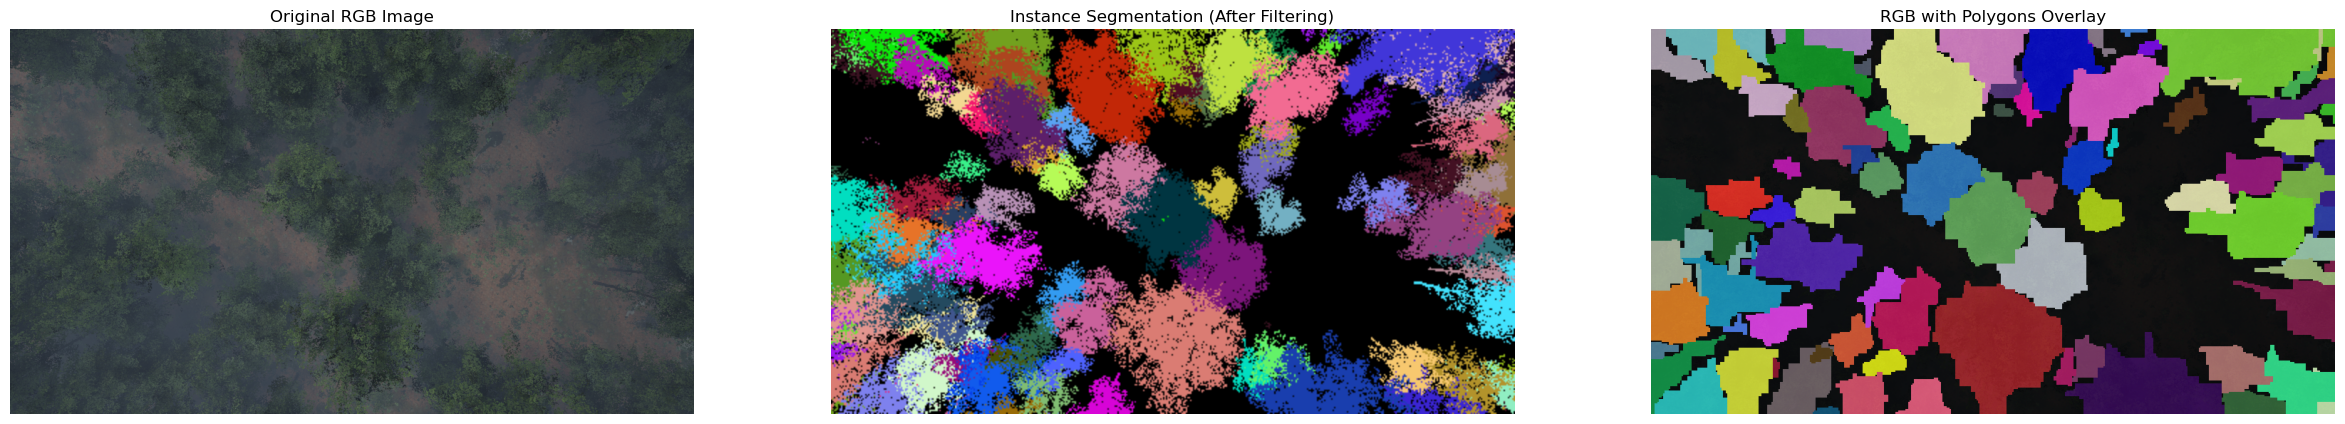

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import os
import pandas as pd

DEBUG = False 

color_palette_path = "color_palette.xlsx"
color_palette = pd.read_excel(color_palette_path) # 4 cols: Index, R, G, B
# take RGB
color_palette = color_palette.iloc[:, 1:].values
color_palette = color_palette.tolist()

def visualize_image(image, title=""):
    if DEBUG:
        plt.figure(figsize=(6, 6))
        plt.imshow(image)
        plt.title(title)
        plt.axis("off")
        plt.show()

# File paths
rgb_image_path = "data/SPREAD/raw/broadleaf/rgb"
instance_image_path = "data/SPREAD/raw/broadleaf/instance_segmentation"

# Get all png files
rgb_images = [f for f in os.listdir(rgb_image_path) if f.endswith(".png")]
instance_images = [f for f in os.listdir(instance_image_path) if f.endswith(".png")]
# Sort
rgb_images.sort()
instance_images.sort()

# Create 1000 random colors to ensure each instance has a unique color
np.random.seed(42)
crown_colors = np.random.randint(0, 255, (1000, 3))
crown_id = 0

for i in range(len(rgb_images)):
    rgb_image = os.path.join(rgb_image_path, rgb_images[i])
    instance_image = os.path.join(instance_image_path, instance_images[i])

    # Area filter threshold
    area_threshold = 225
    min_cluster_size = 5
    min_crown_size = 225

    # Read RGB image and instance segmentation image
    bgr_image = cv2.imread(rgb_image)
    rgb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)
    instance_image = cv2.imread(instance_image)
    instance_image = cv2.cvtColor(instance_image, cv2.COLOR_BGR2RGB)
    
    # Exclude some colors
    # colors_to_exclude = [[255, 255, 255],[158,205,91],[232,242,221],[143,172,22]] # For meadow
    colors_to_exclude = [[255, 255, 255]]
    
    # Convert the above colors to black
    for color in colors_to_exclude:
        instance_image[(instance_image == color).all(axis=2)] = [0, 0, 0]

    # Display
    visualize_image(instance_image)
    
    # Function to filter small area instances
    def filter_small_instances(instance_img, area_threshold):
        filtered_instance_img = instance_img.copy()
        unique_colors, counts = np.unique(instance_img.reshape(-1, instance_img.shape[2]), axis=0, return_counts=True)
        
        for color, count in zip(unique_colors, counts):
            if not np.array_equal(color, [0, 0, 0]):  # Skip background color
                if count < area_threshold:
                    filtered_instance_img[(instance_img == color).all(axis=2)] = [0, 0, 0]  # Set small area instances to background color

        return filtered_instance_img

    # Apply area filter
    filtered_instance_image = filter_small_instances(instance_image, area_threshold)

    # Resize the filtered segmentation image to match the RGB image
    if filtered_instance_image.shape[:2] != rgb_image.shape[:2]:
        filtered_instance_image = cv2.resize(filtered_instance_image, (rgb_image.shape[1], rgb_image.shape[0]))

    # Create a blank layer for drawing polygons
    overlay = np.zeros_like(rgb_image, dtype=np.uint8)

    # Get unique instance colors
    unique_colors = np.unique(filtered_instance_image.reshape(-1, filtered_instance_image.shape[2]), axis=0)
    
    # Only extract colors in the color_palette
    unique_colors = [color for color in unique_colors if list(color) in color_palette]
    
    visualize_image(filtered_instance_image)

    # break

    for color in unique_colors:
        # If not 0,0,0
        if not np.array_equal(color, [0, 0, 0]):
            # Extract the region corresponding to the current color
            mask = cv2.inRange(filtered_instance_image, color, color)
            
            # Remove small pixel clusters
            num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask, connectivity=8)
            clean_mask = np.zeros_like(mask)  # For storing all valid clusters

            for label in range(1, num_labels):  # Start from 1, skip background
                area = stats[label, cv2.CC_STAT_AREA]
                if area >= min_cluster_size:
                    clean_mask[labels == label] = 255  # Keep larger connected regions
            mask = clean_mask
            
            visualize_image(mask)

            test_mask = mask.copy()
            # Perform dilation
            kernel = np.ones((3, 3), np.uint8)
            test_mask = cv2.dilate(test_mask, kernel, iterations=15)
            
            visualize_image(test_mask)
            
            # Get pixel clusters
            num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(test_mask, connectivity=4)
            # print(stats)
            # print(np.unique(labels))
            visualize_image(labels, title="labels")
            
            # Assign different colors to different pixel clusters
            test_mask_with_different_color = np.zeros_like(filtered_instance_image)
            for label in range(1, num_labels):
                test_mask_with_different_color_single = np.zeros_like(filtered_instance_image)
                
                test_mask_with_different_color_single[labels == label] = crown_colors[crown_id]
                
                # If test_mask_with_different_color_single is all zeros, skip
                if np.sum(test_mask_with_different_color_single) == 0:
                    continue
                
                visualize_image(test_mask_with_different_color_single)
                # Perform erosion
                kernel = np.ones((3, 3), np.uint8)
                test_mask_with_different_color_single = cv2.erode(test_mask_with_different_color_single, kernel, iterations=13)
                visualize_image(test_mask_with_different_color_single)
                # Convert to grayscale image
                gray_mask = cv2.cvtColor(test_mask_with_different_color_single, cv2.COLOR_RGB2GRAY)
                # Keep only the largest connected region
                small_num_labels, samll_labels = cv2.connectedComponents(gray_mask, connectivity=4)
                max_label = np.argmax([np.sum(samll_labels == i) for i in range(1, small_num_labels)]) + 1
                test_mask_with_different_color_single[samll_labels != max_label] = 0
                visualize_image(test_mask_with_different_color_single)
                # If the number of pixels in test_mask_with_different_color_single is less than min_crown_size, skip
                if np.sum(test_mask_with_different_color_single != 0) < min_crown_size*3:
                    continue
                test_mask_with_different_color[test_mask_with_different_color_single != 0] = test_mask_with_different_color_single[test_mask_with_different_color_single != 0]
                
                crown_id += 1
            
            visualize_image(test_mask_with_different_color)
            
            # Draw test_mask_with_different_color on overlay
            overlay[test_mask_with_different_color != 0] = test_mask_with_different_color[test_mask_with_different_color != 0]

    # Overlay the polygon layer on the RGB image
    alpha = 0.8
    combined_image = cv2.addWeighted(overlay, alpha, rgb_image, 1-alpha, 0)

    # Visualization
    fig, ax = plt.subplots(1, 3, figsize=(30, 8))
    ax[0].imshow(rgb_image)
    ax[0].set_title("Original RGB Image")
    ax[0].axis("off")

    ax[1].imshow(filtered_instance_image)
    ax[1].set_title("Instance Segmentation (After Filtering)")
    ax[1].axis("off")

    ax[2].imshow(combined_image)
    ax[2].set_title("RGB with Polygons Overlay")
    ax[2].axis("off")

    plt.show()
    
    if i == 0:
        break